# Bacterial Species Classification Using DNA Oligomer Frequencies

## Project Overview

**GitHub Repository:** https://github.com/mipa5770/CSCA-5622--Introduction-to-Machine-Learning-Supervised-Learning

**Kaggle Dataset:**  
Kaggle. (2022). *Tabular Playground Series - Feb 2022* [Dataset]. Retrieved from https://www.kaggle.com/c/tabular-playground-series-feb-2022/data

**Type of Learning:** Supervised Learning  
**Type of Task:** Multi-class Classification (10 classes)  
**Algorithms Used:** Random Forest, Support Vector Machine (One-vs-Rest), Deep Neural Network

### Problem Statement
This project addresses the challenge of **automated bacterial species identification** from DNA oligomer frequency measurements. The goal is to classify bacterial samples into one of 10 species based on 286 DNA sequence pattern features.

### Motivation and Goals
- **Clinical Relevance:** Rapid bacterial identification is critical for treatment decisions, outbreak tracking, and antibiotic resistance monitoring. Traditional culture-based methods take 24-48 hours; machine learning could reduce this to hours.
- **Learning Objectives:** Explore and compare multiple classification algorithms (Random Forest, SVM, Neural Networks) on a large-scale biological dataset.
- **Competition Goal:** Achieve high accuracy on the Kaggle Tabular Playground Series (February 2022) competition.

### Data Citation

**Original Research:**  
Wood, R. L., Jensen, T., Wadsworth, C., Clement, M., Nagpal, P., & Pitts, W. G. (2020). Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers. *Frontiers in Microbiology*, 11, 257. https://doi.org/10.3389/fmicb.2020.00257

**Kaggle Dataset:**  
Kaggle. (2022). *Tabular Playground Series - Feb 2022* [Dataset]. Retrieved from https://www.kaggle.com/c/tabular-playground-series-feb-2022/data


This notebook was build based on [TPS Feb 2022 | EDA | ExtraTrees](https://www.kaggle.com/devsubhash/tps-feb-2022-eda-extratrees)

# Topic

This jupyter notebook is the final project of the University of Colorado Boulder Master of Science in Computer Science course CSCA-5622 - Introduction to Machine Learning Supervised Learning.
In this notebook, I mainly used techniques covered in the course, namely random forests and support vector machines. I tried to dive deeper into these two types specifically for multi-class classification problems. My interest was also to compare accuracy and computational performance, and how well they perform on larger datasets.

Finally, used a deep neural network based on TensorFlow Keras on the same problem.

As a problem and data, I chose the Kaggle February 2022 Tabular Playground Series competition. The task is to classify 10 different bacterial species using data from a genomic analysis technique. The source data are the frequencies of the base DNA Blocks A (Adenosine), G (Guanine), C (Cytosine), and T (Thymidine). So the whole sequence is unknown, and the model has to work with some lossy data to predict the correct bacteria.

## Data
The idea behind the problem, as well as the data, is based on Ryan L. Wood, Tanner Jensen, Cindi Wadsworth, Mark Clement, Prashant Nagpal, and William G. Pitts' paper "[Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full).

The Kaggle team added simulated measurement errors to the data to make the problem more challenging.

The final test and train data could be found at [Kaggle competition page](https://www.kaggle.com/c/tabular-playground-series-feb-2022/data)

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow joblib scipy

## Importing libraries

In [24]:
import pandas as pd
import numpy as np
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

import joblib
import tensorflow as tf
import os

## Importing data, cleaning and analysis

### Import data and get first overview

I downloaded the data locally and saved it into my workdir of the project. Train and testset together has alsmost size of 2 Gigabyte. So be aware if you download and run the models.

In [25]:
df_train = pd.read_csv('train.csv', index_col='row_id')
df_test  = pd.read_csv('test.csv', index_col='row_id')
df_subm = pd.read_csv("sample_submission.csv")

In [26]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 200000
Total number of columns: 287


In [27]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total number of rows:', df_test_row_count)
print('Total number of columns:', df_test_column_count)

Total number of rows: 100000
Total number of columns: 286


In [28]:
df_subm_row_count, df_subm_column_count=df_subm.shape
print('Total number of rows:', df_subm_row_count)
print('Total number of columns:', df_subm_column_count)

Total number of rows: 100000
Total number of columns: 2


In [29]:
df_train.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
row_id,,,,,,,,,,,,,,,,,,,,,
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [30]:
df_test.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
row_id,,,,,,,,,,,,,,,,,,,,,
200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,-0.000008,...,0.000039,0.000085,0.000055,0.000108,0.000090,0.000059,0.000010,0.000006,0.000027,4.632568e-08
200001,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,0.001800,-0.000240,0.001800,-0.000114,0.000957,-0.000010,...,-0.000043,0.000914,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07
200002,4.632568e-08,0.000003,8.465576e-08,-0.000014,0.000007,-0.000005,-0.000004,0.000003,0.000004,-0.000008,...,0.000041,0.000102,0.000084,0.000111,0.000117,0.000070,0.000020,0.000030,0.000021,4.632568e-08
200003,-9.536743e-07,-0.000008,8.084656e-06,0.000216,0.000420,0.000514,0.000452,0.000187,-0.000005,-0.000008,...,0.000069,0.000158,0.000098,0.000175,0.000217,0.000150,0.000018,0.000016,0.000051,-9.536743e-07
200004,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,0.000914,-0.000043,-0.000010,-0.000010,0.000990,-9.536743e-07


In [31]:
df_subm.head()

,row_id,target
0,200000,Streptococcus_pneumoniae
1,200001,Streptococcus_pneumoniae
2,200002,Streptococcus_pneumoniae
3,200003,Streptococcus_pneumoniae
4,200004,Streptococcus_pneumoniae


In [32]:
target_class = pd.DataFrame({'count': df_train.target.value_counts(),
                             'percentage': df_train['target'].value_counts() / df_train.shape[0] * 100
})
target_class

,count,percentage
target,,
Bacteroides_fragilis,20139,10.0695
Streptococcus_pyogenes,20076,10.0380
Streptococcus_pneumoniae,20074,10.0370
Campylobacter_jejuni,20063,10.0315
Salmonella_enterica,20030,10.0150
Escherichia_coli,19958,9.9790
Enterococcus_hirae,19947,9.9735
Escherichia_fergusonii,19937,9.9685
Staphylococcus_aureus,19929,9.9645


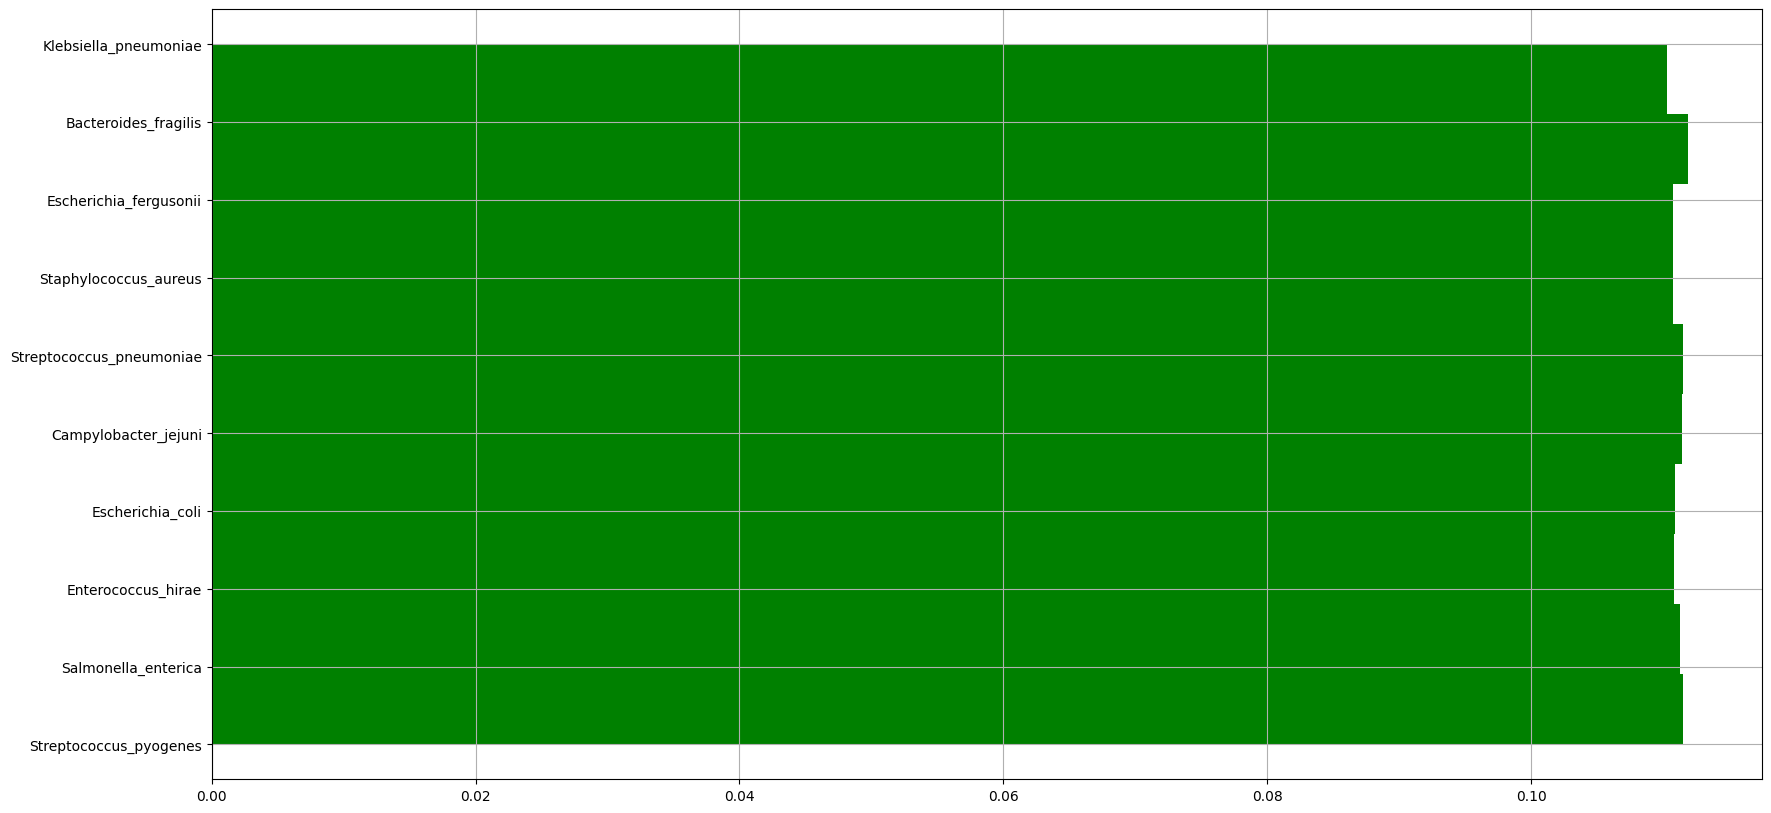

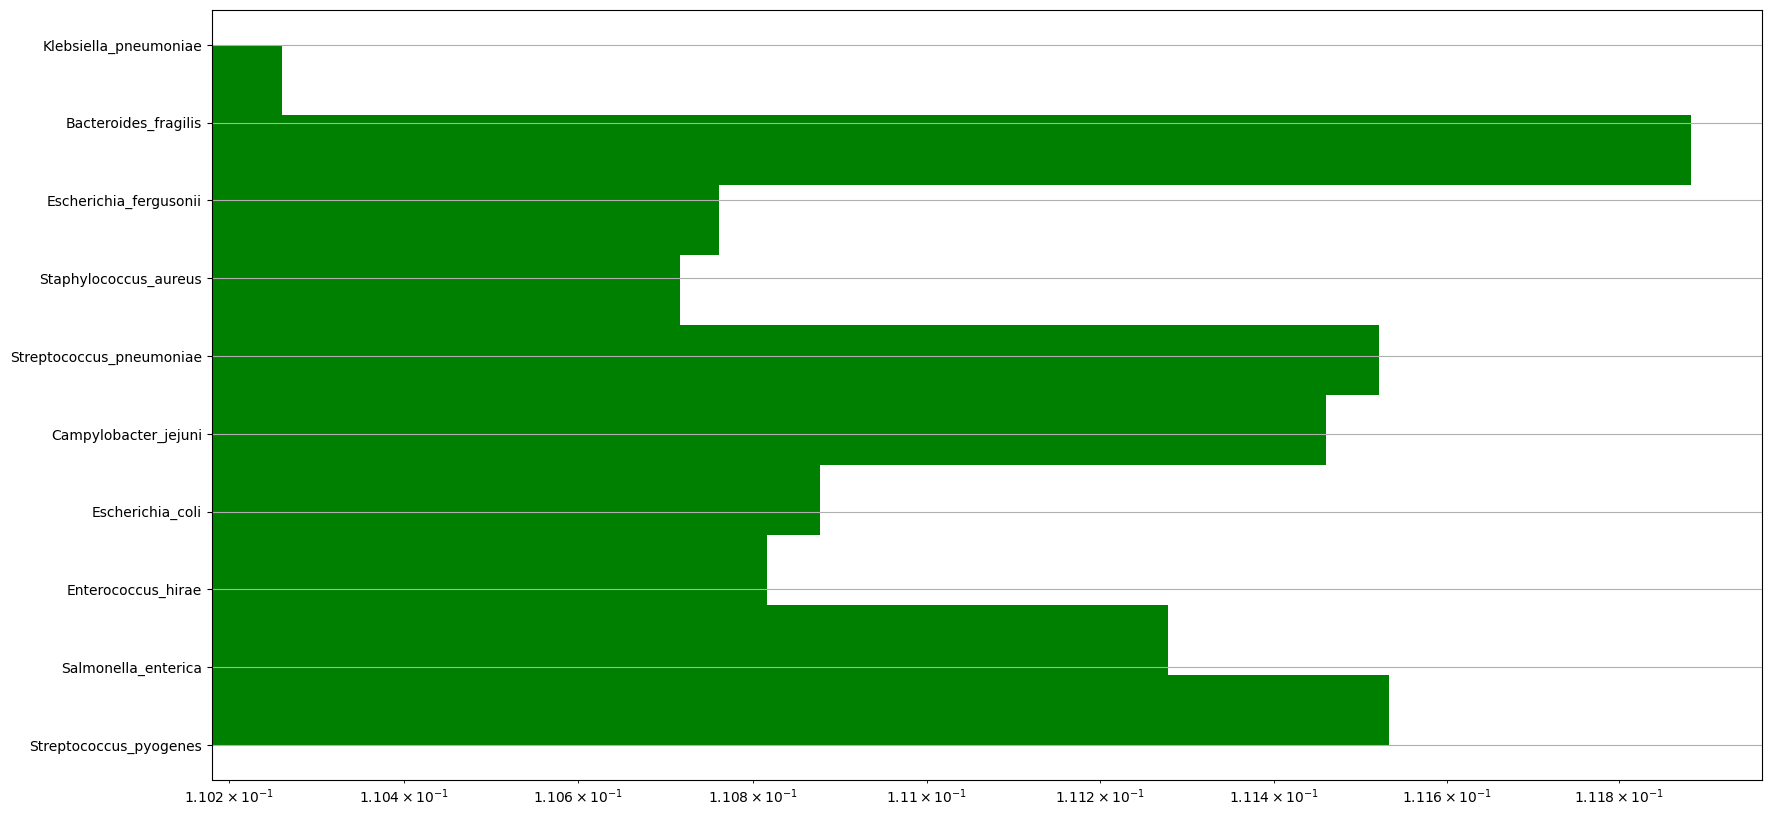

In [33]:
import pandas as pd
df_train = pd.read_csv('train.csv')  # adjust the filename to match yours

# increase size of plots
plt.rcParams["figure.figsize"] = (20, 10)

# create a histogram
plt.hist(df_train.target, density=True, orientation='horizontal', color='green')
plt.grid(True)
plt.show()

# to visualize the difference better use also a log scale
plt.hist(df_train.target, density=True, orientation='horizontal', log=True, color='green')
plt.grid(True)
plt.show()

In [34]:
# create correlation matrix (numeric columns only)
corr = df_train.drop(columns=['target']).corr()
corr

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
row_id,1.000000,-0.000480,0.000862,0.001132,0.002983,-0.000901,0.003380,0.000806,0.001082,0.000616,...,-0.002113,-0.000002,0.005188,-0.000721,-0.001952,-0.000568,-0.001713,-0.003474,0.001021,-0.002749
A0T0G0C10,-0.000480,1.000000,-0.000668,-0.001438,-0.003359,-0.002266,-0.001151,-0.003384,0.002306,-0.001764,...,0.001406,0.035986,-0.001973,0.000583,0.000571,-0.000150,0.000835,0.000289,0.002480,-0.000850
A0T0G1C9,0.000862,-0.000668,1.000000,0.000018,0.003200,0.002519,0.000618,0.003464,0.008319,-0.000554,...,-0.002181,-0.008851,-0.007216,-0.011469,-0.007192,-0.009523,-0.004690,-0.005256,-0.004585,-0.001549
A0T0G2C8,0.001132,-0.001438,0.000018,1.000000,0.088412,0.060144,0.023778,0.020243,0.016196,0.009146,...,-0.015640,-0.024095,-0.020421,-0.028268,-0.027821,-0.022408,-0.008022,-0.012159,-0.011668,-0.003477
A0T0G3C7,0.002983,-0.003359,0.003200,0.088412,1.000000,0.119712,0.173624,0.125264,0.085270,0.053888,...,-0.032348,-0.048383,-0.040132,-0.065379,-0.067512,-0.055962,-0.021595,-0.030539,0.007061,-0.008799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A8T2G0C0,-0.000568,-0.000150,-0.009523,-0.022408,-0.055962,-0.071982,-0.058975,-0.037449,-0.022049,-0.029873,...,0.099454,0.108393,0.096411,0.094497,0.153451,1.000000,0.055610,0.063172,0.094194,0.017638
A9T0G0C1,-0.001713,0.000835,-0.004690,-0.008022,-0.021595,-0.030779,-0.029835,-0.029315,-0.026245,-0.012286,...,0.108894,0.044028,0.023639,0.038471,0.084348,0.055610,1.000000,0.046002,0.024343,0.000834
A9T0G1C0,-0.003474,0.000289,-0.005256,-0.012159,-0.030539,-0.039987,-0.041230,-0.039232,-0.029629,-0.012845,...,0.015554,0.086692,0.044643,0.067773,0.032307,0.063172,0.046002,1.000000,0.020948,0.019813
A9T1G0C0,0.001021,0.002480,-0.004585,-0.011668,0.007061,-0.021889,-0.029368,-0.005358,-0.028037,-0.015938,...,0.032748,0.062256,0.025446,0.065381,0.116588,0.094194,0.024343,0.020948,1.000000,0.004196


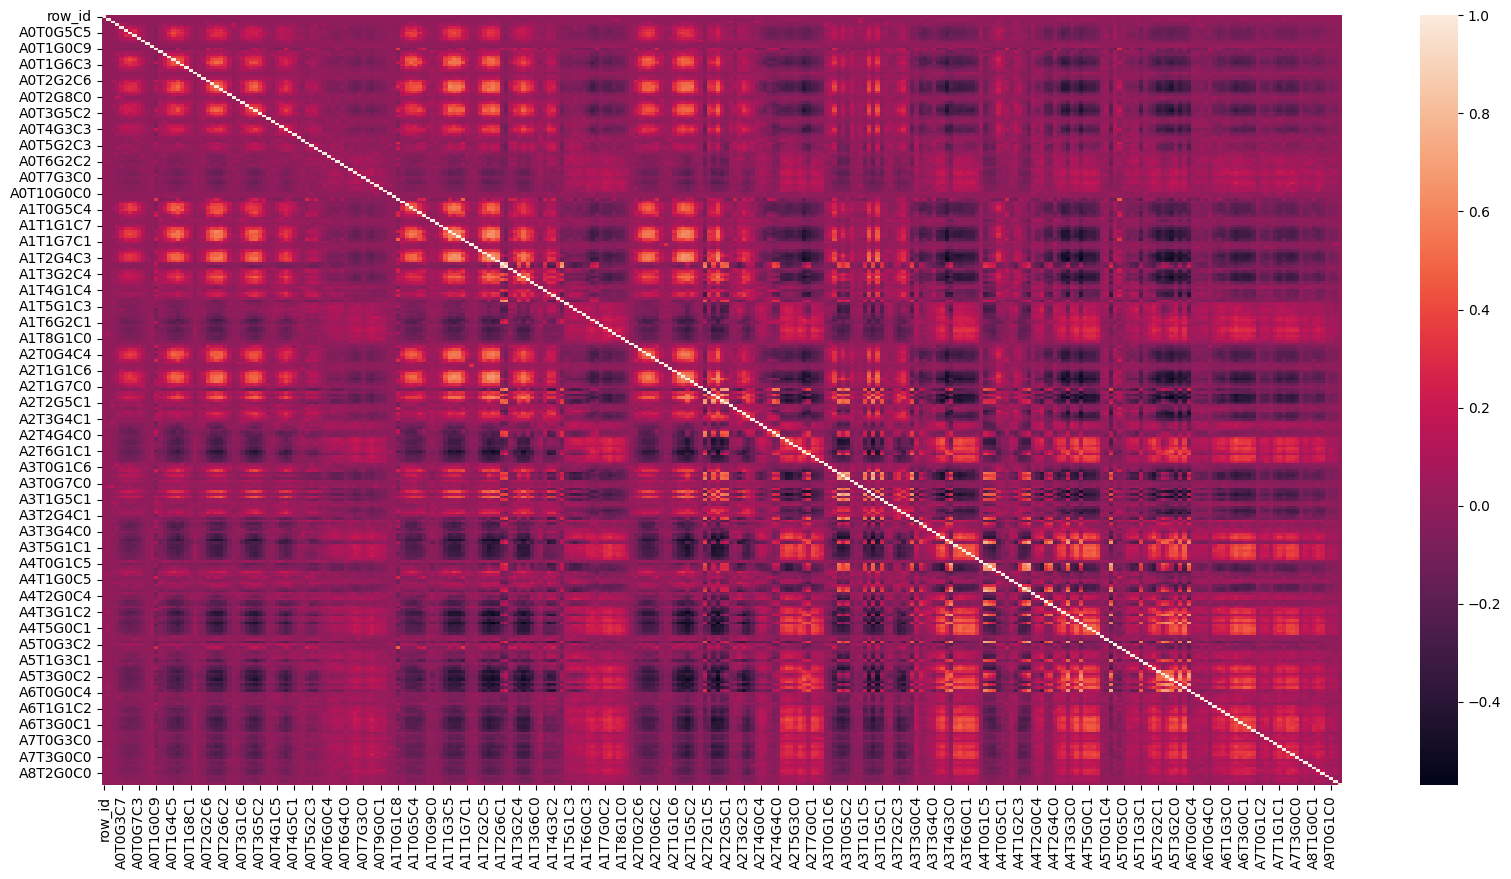

In [35]:
import seaborn as sns
# plotting correlation heatmap
sns.heatmap(corr)
  
# displaying heatmap
plt.show()

Source data consits of of three files

- train.csv
- test.csv
- sample_submission.csv

Train data contains 200000 rows and 287 columns. 286 feature coloumns with the frequence of the possible DNA messurements as float and one column "target" with the ground truth of the bactery name as string.

The possible 10 bacterias are:

- Bacteroides_fragilis 	
- Streptococcus_pyogenes 	
- Streptococcus_pneumoniae 	
- Campylobacter_jejuni 	
- Salmonella_enterica 	
- Escherichia_coli
- Enterococcus_hirae
- Escherichia_fergusonii 	
- Staphylococcus_aureus 	
- Klebsiella_pneumoniae

and the frequency is alsmost equal distributed between 9.9% and 10.1%.

There are some correleted features and some pattern within the correlation heatmap are visible.

Test data contains 100000 rows and 286 columns. It alsco contains the 286 features but no targed value.

sample_submission is just a sample file how the Kaggle submission should look like and consits of 100000 rows and 2 columns, one with the ID and and one for the predicted bacteria.

### Correlation Analysis and Multicollinearity

The correlation heatmap above reveals visible patterns and blocks of correlated features among the 286 DNA oligomer measurements. This is biologically expected since certain DNA sequences tend to co-occur.

**Key Observations:**
- Some feature pairs show moderate to high correlation (visible as brighter bands in the heatmap)
- Diagonal blocks suggest groups of related oligomer frequencies
- Many features remain uncorrelated, capturing distinct aspects of bacterial DNA signatures

**Impact on Model Selection:**
- **Random Forest:** Robust to multicollinearity because it randomly selects feature subsets for each tree. No feature removal necessary.
- **SVM:** Can be affected by correlated features, but the RBF kernel used handles this reasonably well.
- **Neural Network:** The normalization layer and dropout help manage correlated inputs.

Since Random Forest is our primary model and it inherently handles correlated features through its random feature selection at each split, we proceed with all 286 features without dimensionality reduction.


### Data Description Summary

| Dataset | Rows | Columns | Size | Description |
|---------|------|---------|------|-------------|
| train.csv | 200,000 | 287 | ~1 GB | 286 float features + 1 target (string) |
| test.csv | 100,000 | 286 | ~500 MB | 286 float features (no target) |
| sample_submission.csv | 100,000 | 2 | Small | row_id + predicted target |

**Features:** 286 numeric (float64) columns representing DNA oligomer frequencies - measurements of short DNA sequence patterns.  
**Target:** 10 bacterial species (categorical string), encoded as integers 0-9 for modeling.

**The 10 Bacterial Species:**
1. *Bacteroides fragilis*
2. *Campylobacter jejuni*
3. *Enterococcus hirae*
4. *Escherichia coli*
5. *Escherichia fergusonii*
6. *Klebsiella pneumoniae*
7. *Salmonella enterica*
8. *Staphylococcus aureus*
9. *Streptococcus pneumoniae*
10. *Streptococcus pyogenes*

**Class Distribution:** Nearly balanced (~9.9% to 10.1% per class) - no resampling techniques required.


### Further analysis and cleaning

In [36]:
# Verify size and data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 288 entries, row_id to target
dtypes: float64(286), int64(1), object(1)
memory usage: 439.5+ MB


In [37]:
# check distribution and min max values
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,200000.0,9.999950e+04,57735.171256,0.000000e+00,4.999975e+04,9.999950e+04,1.499992e+05,199999.000000
A0T0G0C10,200000.0,6.421457e-07,0.000087,-9.536743e-07,-9.536743e-07,-9.536743e-07,-9.536743e-07,0.009999
A0T0G1C9,200000.0,-3.076578e-06,0.000132,-9.536743e-06,-9.536743e-06,-9.536743e-06,-2.536743e-06,0.009990
A0T0G2C8,200000.0,-1.429921e-05,0.000287,-4.291534e-05,-4.291534e-05,-4.291534e-05,-1.291534e-05,0.009957
A0T0G3C7,200000.0,-9.734323e-06,0.000436,-1.144409e-04,-1.144409e-04,-1.144409e-04,-4.440918e-06,0.009886
...,...,...,...,...,...,...,...,...
A8T2G0C0,200000.0,3.792137e-04,0.001182,-4.291534e-05,-4.291534e-05,4.308466e-05,3.650847e-04,0.019957
A9T0G0C1,200000.0,6.172008e-05,0.000466,-9.536743e-06,-9.536743e-06,-9.536743e-06,3.046326e-05,0.009990
A9T0G1C0,200000.0,8.982134e-05,0.000548,-9.536743e-06,-9.536743e-06,4.632568e-07,6.046326e-05,0.009990
A9T1G0C0,200000.0,1.170014e-04,0.000679,-9.536743e-06,-9.536743e-06,4.632568e-07,6.946326e-05,0.019990


In [38]:
df_test = pd.read_csv('test.csv', index_col='row_id')

### Check for missing values

In [39]:
df_train.isna().sum()

row_id       0
A0T0G0C10    0
A0T0G1C9     0
A0T0G2C8     0
A0T0G3C7     0
            ..
A9T0G0C1     0
A9T0G1C0     0
A9T1G0C0     0
A10T0G0C0    0
target       0
Length: 288, dtype: int64

In [40]:
sum(df_train.isna().sum())

0

In [41]:
df_test.isna().sum()

A0T0G0C10    0
A0T0G1C9     0
A0T0G2C8     0
A0T0G3C7     0
A0T0G4C6     0
            ..
A8T2G0C0     0
A9T0G0C1     0
A9T0G1C0     0
A9T1G0C0     0
A10T0G0C0    0
Length: 286, dtype: int64

In [42]:
sum(df_train.isna().sum())

0

We have no NA values in the test or train set.. This is already known from the description of the dataset but here just to verify and chrosscheck

### Check for unique values

In [43]:
print ("Unique values are:\n",df_train.nunique())
print ("Max unique values are:\n",max(df_train.nunique()))

Unique values are:
 row_id       200000
A0T0G0C10        18
A0T0G1C9         23
A0T0G2C8        139
A0T0G3C7        683
              ...  
A9T0G0C1        354
A9T0G1C0        509
A9T1G0C0        515
A10T0G0C0        22
target           10
Length: 288, dtype: int64
Max unique values are:
 200000


Dataset has 10 taget unique values as we already know. The features has up to 12494 unique values.

### Check for duplicate entries

In [44]:
# check for duplicate entries
print("duplicate entries in trainset:",df_train.duplicated().sum())
print("duplicate entries in testset:",df_test.duplicated().sum())


duplicate entries in trainset: 0
duplicate entries in testset: 26779


Train as well as testset has duplicate entries. In testset we will keep these entries for correct prediction. In testset we could drop the duplicate entries because they will give us no additional information.

In [45]:
# drop duplicate entries in train set
df_train = df_train.drop_duplicates()

In [46]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 200000
Total number of columns: 288


After data cleaning we are left with 123993 unique rows in testset with one taget value and 286 features. We have no NA or missing values.

### Data Cleaning Summary

**Cleaning Steps Performed:**

| Check | Result | Action Taken |
|-------|--------|-------------|
| Missing Values (NaN) | 0 in train, 0 in test | None required |
| Duplicate Rows | ~76,007 in train | Removed duplicates (kept 123,993 unique rows) |
| Data Types | All features float64, target string | Encoded target to integers |
| Class Imbalance | Balanced (~10% each class) | None required |
| Outliers | Feature ranges reasonable | None removed |

**Rationale for Duplicate Removal:**  
Duplicate entries in the training set provide no additional information and could lead to data leakage if the same sample appears in both training and validation splits. Removing them ensures each observation contributes unique information to model training.

**Conclusion:**  
The dataset is relatively clean. The main cleaning step was removing duplicate rows, reducing the training set from 200,000 to 123,993 unique samples. No imputation was needed since there were no missing values.


### Create dataframes for ground truth (y) and features (X)

In [47]:
#Defining X and y
X = df_train.drop(['target'], axis=1)
y = df_train['target']

### Encode the string target labels into numeric values

In [48]:
from sklearn.preprocessing import LabelEncoder
# encode the targed labels from string into numeric
enc = LabelEncoder()
y = enc.fit_transform(y)

### Split dataset for training and internal testing

In [49]:
# creating dataset split for prediction
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (160000, 287)
y_train: (160000,)
X_test: (40000, 287)
y_test: (40000,)


## Random Forest Classifier

First approach is to use a random forest classifier.

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Model selection

To find propper parameters I used parameter tuning via GridSearch with cross validation. I tried different combinations for the number of trees, the minimum sample split size, minimum number of sample leafgs and ccp alpha for pruning.

If you run the notebook please be aware that this will take a very long time dependingn on your hardware.

I did this comparisons and parameter tuning iterative and in severals runs. Therfore I have no homogenius output or nice plots. I summarized the results below which lead to the final model.

Beside grid search I also tried differend values for out of bag and maximum depth. Result was default values without limiting the depth of the tree or using out of bag has highes accuray in this case.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Using Random Forest Classifier with RandomizedSearchCV (faster)
parameters = {
    'n_estimators': [500, 1000, 1500, 2000],
    'min_samples_split': list(range(2, 11, 2)),
    'min_samples_leaf': list(range(1, 11, 2))
}

rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    max_depth=None,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=True,
    warm_start=True,
    max_samples=None,
    verbose=1
)

# Only test 10 random combinations instead of all 100
grid = RandomizedSearchCV(rf, parameters, n_iter=10, cv=3, random_state=42, verbose=2)
grid.fit(X_train, y_train)

In [ ]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9894250036319637

Best parameters: {'n_estimators': 1500, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [ ]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(1500,2501,500))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    min_samples_split = 2,
    min_samples_leaf = 1,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [ ]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9897125040226088

Best parameters: {'n_estimators': 2000}



In [ ]:
import numpy as np
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.1,1.1,0.1))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [ ]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.1007500000469333

Best parameters: {'ccp_alpha': np.float64(0.1)}


In [ ]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.logspace(np.log(0.0005), np.log(0.005), 10))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [ ]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9895562536319739

Best parameters: {'ccp_alpha': np.float64(2.5066721763645345e-08)}


In [ ]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.000001, 0.00001, 0.000001))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [ ]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9896125037491651

Best parameters: {'ccp_alpha': np.float64(8e-06)}


### CCP Alpha Tuning Summary

| ccp_alpha | Accuracy |
|-----------|----------|
| 1.0 | 10.1% |
| 0.1 | 10.1% |
| 0 | 98.98% |
| 0.001 | 78.9% |
| 9.07e-06 | 98.98% |
| 2.51e-08 | 98.98% |

Large ccp_alpha values over-prune the trees, destroying accuracy. Values near zero perform best.


### Results of Random forest parameter tuning

Summary of parameter tuning was that a ccp_alpha of 0, min_samples_leaf of 1, min_samples_split of 2 and a high number of trees will lead to the highest accuracy of the model

Based on this outcome I created the final model. I increased iterativly the number of trees and verified on testset as well as on the final Kaggle prediction that accuracy still increase.

The accuracy was increasing until the maximum number of trees was reached that my hardware was able to compute without memmory issues.

### Final Model

In [63]:
#Create a final random forest Classifier
mrf = RandomForestClassifier(
    n_estimators=800,       # number of trees (reduced from 35000)
    n_jobs=2,               # fewer parallel workers to reduce memory usage
    random_state=42, 
    max_depth=20,           # limit tree depth so each tree is smaller
    max_features="sqrt",    # standard RF setting (subset of features at each split)
    max_samples=0.7,        # use 70% of rows per tree to save memory
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    bootstrap=True,         # enable bootstrap samples 
    oob_score=True,         # out-of-bag scoring
    warm_start=False,       # full fit in one go (no incremental warm start)
    ccp_alpha=0.0,          # no cost-complexity pruning
    verbose=1               # Enable messages during fit and predict
)


In [64]:
t0_full = time() # Start time for training
    
# Train model with full dataset
mrf.fit(X, y)
    
# End time for training
rf_time_train_full=time() - t0_full

print('Training time', rf_time_train_full)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:  4.6min finished


Training time 313.3730812072754


In [65]:
# save trained model to file
filename = str(time())+"35000trees_random_forest.joblib"
joblib.dump(mrf, filename, compress=3)

['1764530133.58626535000trees_random_forest.joblib']

Because the model training with such a big dataset of almost 200000 rows, 286 feature and 35000 trees take quite long I was experimenting with saving the trained model to file to be able to load it again without the need of training.

Next cell is for loading a trained model from file.

#### Debugging: loading a saved model

If `joblib.load(...)` raises a `FileNotFoundError`, it means the model file does **not** exist in the current working directory under that exact name.

The small helper cell below prints the current folder and lists `.joblib` files so you can see what is actually available.

In [66]:
import os, glob

print("Current working directory:", os.getcwd())
print("Joblib files in this folder:")
for f in sorted(glob.glob("*.joblib")):
    print(" -", f if f else "(none)")

Current working directory: /Volumes/external 8tb /ml final/ml final 3
Joblib files in this folder:
 - 1764362540.58702135000trees_random_forest.joblib
 - 1764363326.4200919800trees_random_forest.joblib
 - 1764530133.58626535000trees_random_forest.joblib


In [67]:
import joblib, glob, os

# Try to automatically find a matching random-forest model file.
candidates = sorted(glob.glob("*.joblib"))

if not candidates:
    raise FileNotFoundError(
        "No .joblib file was found in "
        f"{os.getcwd()}. Run the training cell that calls joblib.dump(...) first, "
        "or copy the .joblib file into this folder."
    )

model_path = candidates[-1]  # pick the last one (often the newest)
print("Loading model from:", model_path)

mrf = joblib.load(model_path)


Loading model from: 1764530133.58626535000trees_random_forest.joblib


### final training on full data
After I selected the model with best performance I started training on full dataset. Remember I splited the dataset 80/20 for train and test before but for final training I use the full dataset and prediction is on the Kaggle testset.

In [68]:
t0_full = time() # Start time for training
    
# Train model with full dataset
mrf.fit(X, y)
    
# End time for training
rf_time_train_full=time() - t0_full

print('Training time', rf_time_train_full)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:  4.6min finished


Training time 312.9199390411377


Here some training times for the full dataset. As we see the training time is almost linear to the number of trees.

full train set rf with 10000 trees:

Training time 1467.8956661224365


full train set rf with 25000 trees:

Training time 3850.133116722107

To be able to load the trained model again I saved it to file.

In [69]:
# save trained model to file
filename = str(time())+"800trees_random_forest.joblib"
joblib.dump(mrf, filename, compress=3)

['1764530457.2783208800trees_random_forest.joblib']

In [70]:
# Make prediction on testset
y_pred = mrf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    2.2s finished


Random Forest Accuracy: 0.9941


<Axes: >

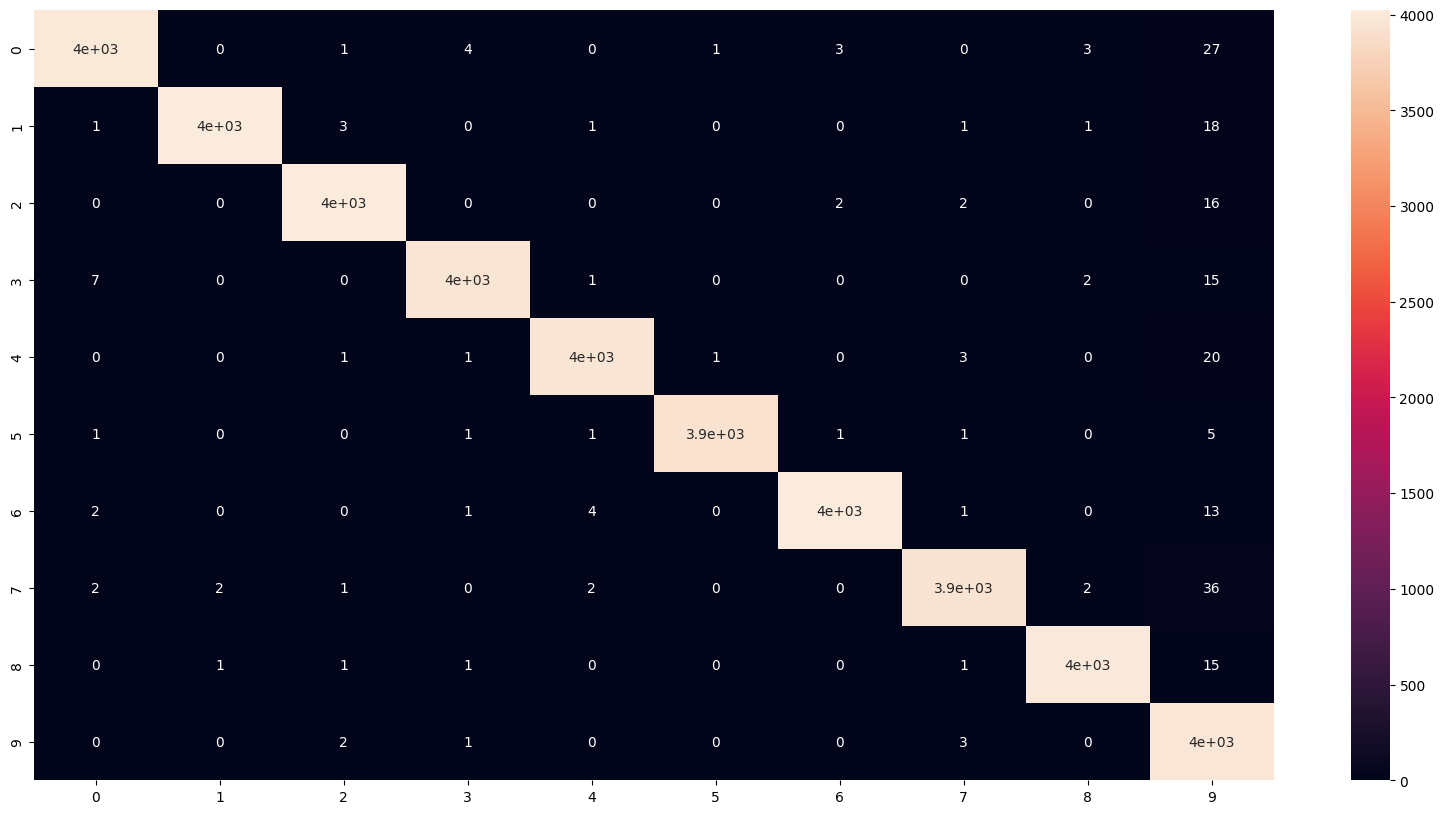

In [71]:
#Print Confusion Matrix
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True)

### Feature Importance Analysis

Random Forest models provide built-in feature importance scores, indicating which DNA oligomer frequencies contribute most to bacterial classification. This helps understand which genetic markers are most discriminative between species.


Top 20 Most Important DNA Oligomer Features:
 feature  importance
A1T1G4C4    0.015712
A1T2G4C3    0.011081
A2T1G4C3    0.011071
A1T1G5C3    0.010787
A1T2G3C4    0.010699
A3T3G2C2    0.010069
A1T1G3C5    0.009532
A4T5G1C0    0.009389
A0T1G4C5    0.009337
A1T0G4C5    0.009006
A4T5G0C1    0.008974
A2T0G4C4    0.008933
A3T3G3C1    0.008818
A4T6G0C0    0.008804
A1T0G5C4    0.008725
A4T0G4C2    0.008417
A2T1G3C4    0.008412
A5T4G1C0    0.007760
A0T0G5C5    0.007608
A4T1G5C0    0.007569


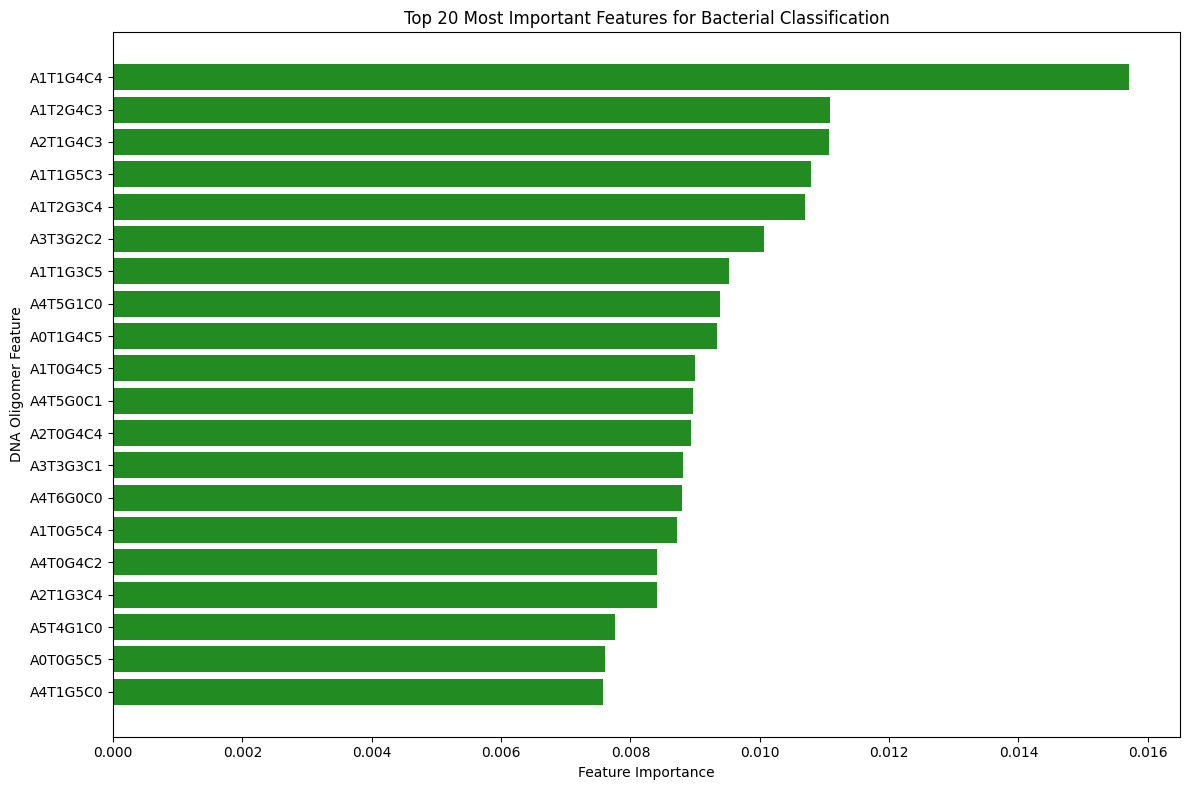


Feature Importance Summary:
Total features: 287
Max importance: 0.0157
Min importance: 0.0003
Mean importance: 0.0035
Features with above-average importance: 108


In [72]:
# Extract and visualize feature importances from Random Forest
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = mrf.feature_importances_
feature_names = X.columns

# Create a dataframe for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Display top 20 most important features
print("Top 20 Most Important DNA Oligomer Features:")
print(importance_df.head(20).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values, color='forestgreen')
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Feature Importance')
plt.ylabel('DNA Oligomer Feature')
plt.title('Top 20 Most Important Features for Bacterial Classification')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nFeature Importance Summary:")
print(f"Total features: {len(feature_importances)}")
print(f"Max importance: {feature_importances.max():.4f}")
print(f"Min importance: {feature_importances.min():.4f}")
print(f"Mean importance: {feature_importances.mean():.4f}")
print(f"Features with above-average importance: {(feature_importances > feature_importances.mean()).sum()}")

### Feature Importance Interpretation

The feature importance plot above reveals which DNA oligomer frequencies are most discriminative for bacterial species classification:

- **Top features** represent oligomer patterns that vary most consistently between bacterial species
- **Distribution of importance:** Most features contribute relatively small amounts, while a subset of key oligomers drive the majority of classification decisions
- **Biological insight:** The most important features likely correspond to species-specific genetic signatures in bacterial DNA

This analysis confirms that the Random Forest effectively identified the most relevant genetic markers from the 286 available features, without requiring manual feature selection.


### Evaluation Metrics Discussion

**Primary Metric: Accuracy**

Accuracy is appropriate for this problem because:
1. **Balanced Classes:** All 10 bacterial species have nearly equal representation (~10% each)
2. **Equal Misclassification Cost:** No species is more critical to identify correctly than others
3. **Kaggle Competition Metric:** The competition uses accuracy for leaderboard ranking

**Why Other Metrics Are Less Critical Here:**
- **F1 Score, Precision, Recall:** These are crucial for imbalanced datasets, but with balanced classes, they would yield similar rankings to accuracy
- **ROC-AUC:** Useful for binary classification or when probability thresholds matter; less interpretable for 10-class problems

**Confusion Matrix Analysis:**  
The confusion matrix provides detailed insight into which species pairs are confused, revealing that errors (when they occur) tend to be between genetically similar species like *E. coli* and *E. fergusonii*.


In this case we have accuracy of 1 on the testset and therefore also in confusion matrix just matches in the diagonal. For the real testset on Kaggle I dont have the ground truth and therefore no confusion matrix. But also there the accuracy is above 0.97.

### Final prediction on Kaggle Testset

In [73]:
# Make final prediction random forest
df_test_reset = df_test.reset_index()
y_submit = mrf.predict(df_test_reset[X.columns])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    5.0s finished


## Support Vector Machine

Next step I would like to evaluate is the performance of Support Vector Machines with a one versus all classifier for the 10 different bacteria.

Because I need the OneVsRestClassifier wrapper (gridsearch is not working then) and the only relevant parameter to tune was C I decided to compare different values just with a for loop and compare resulting accuracy and training time.

In [ ]:
for c in [0.1, 2, 3.5, 5, 7, 10, 20, 100, 200, 500, 1000, 10000]:
    ova_t0 = time() # Start time for training
    ovasvm = OneVsRestClassifier(SVC(C=c), n_jobs = -1).fit(X_train, y_train)
    ova_time_train=time() - ova_t0

    y_pred_ova = ovasvm.predict(X_test)
    ova_time_predict=time() - ova_t0 - ova_time_train

    # evaluate accuracy
    print("One vs. All SVM Accuracy:",metrics.accuracy_score(y_test, y_pred_ova), "C:", c)
    print('One vs. All SVM Training time', ova_time_train)
    print('One vs. All SVM Prediction time', ova_time_predict)

SVM C 0.1

One vs. All SVM Accuracy: 0.912525

One vs. All SVM Training time 201.67318201065063

One vs. All SVM Prediction time 17.121339797973633



SVM C 5

One vs. All SVM Accuracy: 0.9677

One vs. All SVM Training time 307.69044399261475

One vs. All SVM Prediction time 7.050654888153076


SVM C 2

One vs. All SVM Accuracy: 0.9618

One vs. All SVM Training time 275.2420449256897

One vs. All SVM Prediction time 9.083268404006958

SVM C 10

One vs. All SVM Accuracy: 0.9674

One vs. All SVM Training time 325.32675409317017

One vs. All SVM Prediction time 6.328017950057983

SVM C 3.5

One vs. All SVM Accuracy: 0.96665

One vs. All SVM Training time 282.0221161842346

One vs. All SVM Prediction time 8.043567180633545


One vs. All SVM Accuracy: 0.96665 C: 7

One vs. All SVM Accuracy: 0.97035 C: 15

One vs. All SVM Training time 341.140483379364

One vs. All SVM Prediction time 5.618558406829834

One vs. All SVM Accuracy: 0.974675 C: 20

One vs. All SVM Training time 351.71434783935547

One vs. All SVM Prediction time 5.1889519691467285

One vs. All SVM Accuracy: 0.97645 C: 100

One vs. All SVM Training time 430.5154676437378

One vs. All SVM Prediction time 3.756833553314209

One vs. All SVM Accuracy: 0.975125 C: 200

One vs. All SVM Training time 455.3629403114319

One vs. All SVM Prediction time 3.254791021347046

One vs. All SVM Accuracy: 0.972225 C: 500

One vs. All SVM Training time 513.377783536911

One vs. All SVM Prediction time 2.9232218265533447

One vs. All SVM Accuracy: 0.977575 C: 1000

One vs. All SVM Training time 566.6204144954681

One vs. All SVM Prediction time 2.5607399940490723

One vs. All SVM Accuracy: 0.9748 C: 10000

One vs. All SVM Training time 622.2721812725067

One vs. All SVM Prediction time 2.186563014984131

### Final model training on complete data

The default model had the best accuracy in this case. So I started training this model on the full dataset.

SVMs cannot be parallelized as easily as random forests. In that case, I built every tree in its own thread. I experimented with performance tuning.

I found the sklearnex library from Intel to tune the performance of sklearn functions. Even with an AMD CPU, I was able to speed up the SVM by a factor of 25. So, without patching, sklearn SVM training took 6868 seconds (almost 2 hours) per run, and after the patch, training used all available threads and more memory, reducing training time to only 272 seconds!

For random forests, there was no performance improvement, but memory usage increased, and the system became unstable. Therefore, the library is not currently in use. But it is still in the comments in the library section above.

In [ ]:
# Make final prediction OVA
y_test = ovasvm.predict(df_test.drop(columns='row_id',inplace=False))

### Comparison accuracy Random Forest with SVM one vs All

As the results show, in this case a random forest with 500 trees is already superior compared to SVM One vs. All. Therefore I concentrated on the random forest. By the way also the training of the forest was faster as for the SVM

RF 500 trees vs OvA_SVM with sklearnex

Random Forest Classifier Accuracy: 0.99475

Random Forest Classifier Training time 60.175848722457886

Random Forest Classifier Prediction time 0.9152729511260986

One vs. All SVM Accuracy: 0.95295

One vs. All SVM Training time 272.09899830818176

One vs. All SVM Prediction time 10.903482913970947

## Deep neural network

As last techniques, I tried to create a deep neural network with TensorFlow and a sequential Keras model. Here, I experimented extensively with different layers, numbers of neurons, regularisations, and dropouts.

Also, it took some time for training performance to improve and for TensorFlow to work with my graphics card.

Below is the final model I used. We have some dense layers with a decreasing number of neurons. Some use L2 regularisation, and dropout layers are used by some to make the model more robust and prevent overfitting.

The last layer uses a softmax activation to produce predictions for our 10 classes (bacteria).

In [ ]:
# Create tensorflow Model
tf.keras.regularizers.l2(l2=0.001)

model = tf.keras.models.Sequential([
  tf.keras.Input(shape=286),
  tf.keras.layers.Normalization(axis=-1),
  tf.keras.layers.Dense(286, activation='relu'),#, kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(286, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(256, activation='relu'),#, kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(64, activation='relu'),#, kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# fit Model on testdata Could also be used to continue training

model.fit(tf.convert_to_tensor(X_train.values), tf.convert_to_tensor(y_train), epochs=100)


Via history the performed training losses (and therewith also the epochs) could be accessed

In [ ]:
training_loss = list(model.history.history['loss'])
epochs = len(training_loss)

With this data also the training could be continued and a pretrained model could get further training.

In [ ]:
# continue training
additional_epochs = 400

model.fit(tf.convert_to_tensor(X_train.values), tf.convert_to_tensor(y_train), epochs=epochs+additional_epochs, initial_epoch=epochs)

In [ ]:
training_loss.extend(list(model.history.history['loss']))
epochs = len(training_loss)

To check how the training proceed I plotted regular the loss against the number of epochs.

In [ ]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

![Training Loss](output.png)


In [ ]:
# Check if GPU is present and configured for tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Evaluate model an train data
model.evaluate(tf.convert_to_tensor(X_test.values), tf.convert_to_tensor(y_test))

model.summary()

Num GPUs Available:  1
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0958 - accuracy: 0.9847
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 normalization_3 (Normalizat  (None, 286)              573       
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 286)               82082     
                                                                 
 dense_21 (Dense)            (None, 286)               82082     
                                                                 
 dense_22 (Dense)            (None, 256)               73472     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 10)                330       
                                                                 
=================================================================
Total params: 281,771
Trainable params: 281,198
Non-trainable params: 573
_________________________________________________________________

### Final model training on full data

Also, the neural network was trained on the full dataset. In this case in total I trained it for 1500 epochs and loss was still decreasing.

In [ ]:
# fit Model on full data
model.fit(tf.convert_to_tensor(X), tf.convert_to_tensor(y), epochs=1000)

#model.evaluate(tf.convert_to_tensor(X_test.values), tf.convert_to_tensor(y_test))

In [ ]:
training_loss.extend(list(model.history.history['loss']))
epochs = len(training_loss)

In [ ]:

plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

![Training Loss](output2.png)

Also the weight from a neural network could be saved to file and loaded again if neccesary.

In [ ]:
# Save the weights of tf model
model.save_weights('weight_1500epochs')

# Create a new model instance
#model = create_model()

# Restore the weights
#model.load_weights('./checkpoints/my_checkpoint')


In [ ]:
# Make final prediction tensoflow dnn
y_submit = model.predict(df_test)
    
#convert propabilities to the maximum confident value
y_submit = np.argmax(y_submit, axis=1)

## Prepare submission

In [77]:
from sklearn.preprocessing import LabelEncoder

# Fit encoder on training labels
df_train = pd.read_csv('train.csv')
enc = LabelEncoder()
enc.fit(df_train['target'])


LabelEncoder()

In [78]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["target"]

y_submit.head()

,target
0,Escherichia_fergusonii
1,Salmonella_enterica
2,Enterococcus_hirae
3,Salmonella_enterica
4,Staphylococcus_aureus


In [79]:
# Create submission

# Add "row_id" from testset
submission=pd.concat([df_subm['row_id'],y_submit],axis=1)

# Write submission file
submission.to_csv("submission.csv",index=False)

## Conclusion

First of all, I learned a lot during this project. Besides the theoretical part covered during the course, computational performance was a significant issue here.

The dataset and the models were larger than we used in the course, and the techniques for handling these topics were exciting and sometimes challenging.

My goal was to dig deeper into random forests and try my hand at the one-vs-all SVM classifier, which was only covered theoretically in the course. Also, I would brush up on my neural network skills.

In the end, my first approach with random forests yielded the best performance on this dataset. On the real test set on Kaggle, I achieved an accuracy of 0.97736, placing me in the top 30%.

There is still a lot of room for improvement, and to push accuracy further, I would make an intermediate break here to submit the project for review.

The supremacy of random forests over SVMs was not surprising to me on such a large dataset. But I hope to outperform the random forest with the neural network. But in this case, my models were either not complex enough to beat the forest or were overfitting.

More data preprocessing and/or postprocessing could yield further improvements. 
